In [1]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os
for file in os.listdir("./input"):
    print(file)

Using TensorFlow backend.


imdb_master.csv
imdb_master_filtered backup.csv
imdb_master_filtered.csv
labeledTrainData.tsv
sampleSubmission.csv
testData.tsv
unlabeledTrainData.tsv
word2vec-nlp-tutorial


In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [6]:
usecols = ['sentiment','review']
train_data = pd.read_csv('./input/labeledTrainData.tsv', delimiter='\t')
additional_data = pd.read_csv('./input/imdb_master_filtered.csv')
additional_data.columns = usecols
unlabeled_data = pd.read_csv("./input/unlabeledTrainData.tsv", delimiter='\t', error_bad_lines=False)
submission_data = pd.read_csv("./input/testData.tsv", delimiter='\t')

b'Skipping line 43043: expected 2 fields, saw 3\n'


In [7]:
datasets = [train_data, additional_data, unlabeled_data, submission_data]
titles = ['Train data', 'Additional data', 'Unlabeled train data', 'Submission data']
for dataset, title in zip(datasets,titles):
    print(title)
    dataset.info()
    display(dataset.head())

Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


Additional data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50000 non-null  int64 
 1   review     50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


,sentiment,review
0,0,Once again Mr. Costner has dragged out a movie...
1,0,This is an example of why the majority of acti...
2,0,"First of all I hate those moronic rappers, who..."
3,0,Not even the Beatles could write songs everyon...
4,0,Brass pictures (movies is not a fitting word f...


Unlabeled train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      49998 non-null  object
 1   review  49998 non-null  object
dtypes: object(2)
memory usage: 781.3+ KB


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


Submission data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [8]:
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 149998


In [9]:
train_data = pd.concat((train_data, additional_data[additional_data.sentiment != -1]),
                       axis=0, ignore_index=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  75000 non-null  int64 
 2   review     75000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


# Check class balance

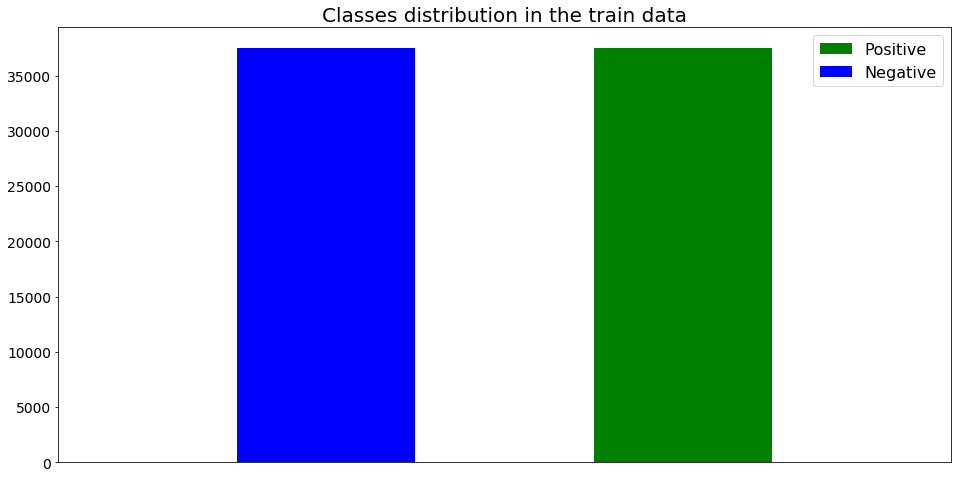

In [10]:
plt.hist(train_data[train_data.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [11]:
def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [12]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [16]:
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

In [17]:
X_train_data = all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values
X_submission = all_reviews[125000: 150000]

In [18]:
train_data['review_lenght'] = np.array(list(map(len, X_train_data)))
median = train_data['review_lenght'].median()
mean = train_data['review_lenght'].mean()
mode = train_data['review_lenght'].mode()[0]

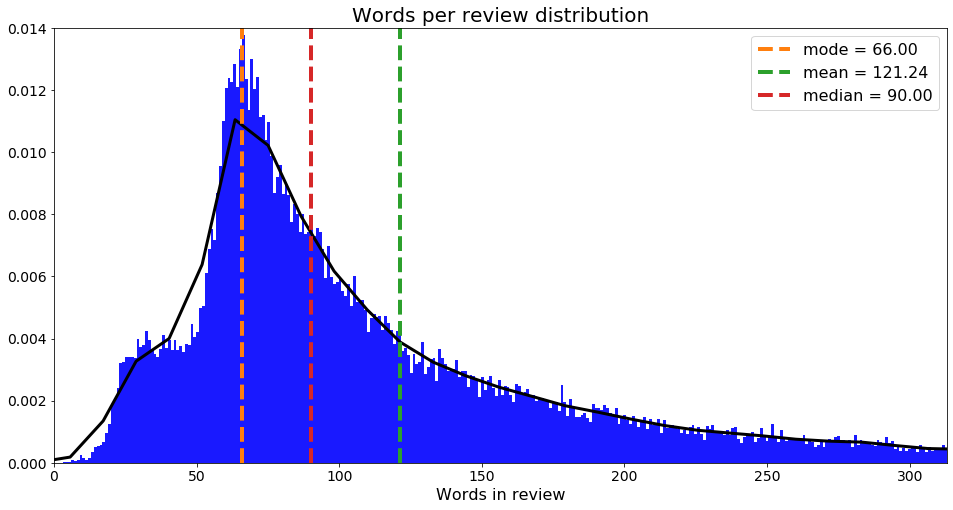

In [19]:
fig, ax = plt.subplots()
sb.distplot(train_data['review_lenght'], bins=train_data['review_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()